In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
!pip install underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.1 MB/s eta 0:00:00


In [ ]:
!pip install pycaret

In [ ]:
# !pip install requests

In [ ]:
%cd "/content/gdrive/MyDrive/Colab Notebooks/DL07_K304_VoMinhTri_PhamThiThuThao/Project01"
#%cd "/content/gdrive/MyDrive/DL07_K304_VoMinhTri_PhamThiThuThao/Project01"

/content/gdrive/.shortcut-targets-by-id/1ilSInCpNcctsJIBTsV6ACpsv3tz9XsyZ/DL07_K304_VoMinhTri_PhamThiThuThao


##**IMPORT THƯ VIỆN VÀ LOAD DỮ LIỆU**

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from underthesea import word_tokenize
from underthesea import pos_tag
from wordcloud import WordCloud
#from pycaret.classification import *
#from langdetect import detect
#from gensim.models.phrases import Phrases

In [ ]:
#Bước 1: Load dữ liệu
df = pd.read_excel("Reviews.xlsx")
df = df.dropna()
df.head(3)

,id,Company Name,Cmt_day,Title,What I liked,Suggestions for improvement,Rating,Salary & benefits,Training & learning,Management cares about me,Culture & fun,Office & workspace,Recommend?
0,4,Accenture,March 2025,"Môi trường thoải mái, ít áp lực, có thể làm vi...","Môi trường thoải mái, ít áp lực, có thể làm vi...",Cần đánh giá KPI khách quan và phân chia công ...,4,4,4,4,4,4,Yes
1,4,Accenture,January 2025,Công ty trẻ trung năng động,"Cơ sở vật chất đẹp, công ty trẻ trung năng độn...",Nên nghiên cứu lại range lương của thì trường....,4,3,4,4,4,5,Yes
2,4,Accenture,October 2023,Môi trường làm việc thoải mái vui vẻ,"Mội người thân thiện, giúp đỡ lẫn nhau. Chương...",Do công ty làm outsourcing về mảng system nên ...,3,3,3,3,3,3,Yes


In [ ]:
#Xem thông tin cơ bản của dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8411 entries, 0 to 8416
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   id                           8411 non-null   int64 
 1   Company Name                 8411 non-null   object
 2   Cmt_day                      8411 non-null   object
 3   Title                        8411 non-null   object
 4   What I liked                 8411 non-null   object
 5   Suggestions for improvement  8411 non-null   object
 6   Rating                       8411 non-null   int64 
 7   Salary & benefits            8411 non-null   int64 
 8   Training & learning          8411 non-null   int64 
 9   Management cares about me    8411 non-null   int64 
 10  Culture & fun                8411 non-null   int64 
 11  Office & workspace           8411 non-null   int64 
 12  Recommend?                   8411 non-null   object
dtypes: int64(7), object(6)
memory usage: 1

In [ ]:
#Xem giá trị điểm nhập không hợp lệ (nếu có)
score_cols = [
    'Rating',
    'Salary & benefits',
    'Training & learning',
    'Management cares about me',
    'Culture & fun',
    'Office & workspace'
]

invalid_scores = df[score_cols].apply(lambda col: ((col < 1) | (col > 5)).sum())
print("🔎 Số lượng Điểm đánh giá không hợp lệ (<1 hoặc >5) trong từng cột:")
print(invalid_scores)

🔎 Số lượng Điểm đánh giá không hợp lệ (<1 hoặc >5) trong từng cột:
Rating                       0
Salary & benefits            0
Training & learning          0
Management cares about me    0
Culture & fun                0
Office & workspace           0
dtype: int64


##**TIỀN XỬ LÝ VĂN BẢN**
- Gộp nội dung 2 cột "What I like" + "Suggestions for improvement" = "clean_text"
- Văn bản thô được chuyển thành chữ thường, bỏ dấu câu,
- Chuyển tiếng Anh thành tiếng Việt, dịch nghĩa teen_code
- Tokenize thành các cụm từ (Danh từ(N) + Tính từ(A)) và (Danh từ(N) + "Không" + Tính từ(A))
- Hiển thị nội dung các cụm từ cơ bản bằng Wordcloud

In [ ]:
#Gộp 2 cột thành 1
df['clean_text_2'] = df['What I liked'].fillna('') + ' ' + df['Suggestions for improvement'].fillna('')

In [ ]:
#LOAD TRANSLATE ENGLISH -> VNMESE
file = open('files/english-vnmese_rev.txt', 'r', encoding="utf8")
english_lst = file.read().split('\n')
english_dict = {}
for line in english_lst:
    key, value = line.split('\t')
    english_dict[key] = str(value)
file.close()

#LOAD TEENCODE
file = open('files/teencode.txt', 'r', encoding="utf8")
teen_lst = file.read().split('\n')
teen_dict = {}
for line in teen_lst:
    key, value = line.split('\t')
    teen_dict[key] = str(value)
file.close()

#LOAD STOPWORDS
file = open('files/vietnamese-stopwords_rev.txt', 'r', encoding="utf8")
stopwords_lst = file.read().split('\n')
file.close()

#LOAD WRONGWORD
file = open('files/wrong-word_rev.txt', 'r', encoding="utf8")
wrong_lst = file.read().split('\n')
file.close()

In [ ]:
# Làm sạch văn bản
def clean_text(text):
    text = text.lower() #Hoa -> thường
    text = re.sub(rf"[{string.punctuation}]", "", text) #Bỏ dấu câu
    return text

def translate_english(text, trans_dict):
    words = text.split()
    translated = [trans_dict.get(word, word) for word in words]
    return " ".join(translated)

def fix_teencode(text, mapping):
    words = text.split()
    corrected = [mapping.get(word, word) for word in words]
    return " ".join(corrected)

def remove_wrongword(text, wrong_dict):
    words = text.split()
    trueword = [word for word in words if word not in wrong_dict]
    return " ".join(trueword)

def remove_stopword(text, stopword_dict):
    words = text.split()
    stopword = [word for word in words if word not in stopword_dict]
    return " ".join(stopword)

def clean_pipeline(text):
    text = clean_text(text)
    text = translate_english(text, english_dict)
    text = fix_teencode(text, teen_dict)
    text = remove_wrongword(text, wrong_lst)
    text = remove_stopword(text, stopwords_lst)
    return text
df['clean_text_2'] = df['clean_text_2'].apply(clean_pipeline)

In [ ]:
df['clean_text_2'].head()

,clean_text_2
0,môi trường thoải mái áp lực thể kết hợp lương ...
1,cơ sở vật chất đẹp công trẻ năng động chế độ k...
2,mội thân thiện giúp đỡ lẫn chương trình intern...
3,tốt env viên trường học cải thiện khả năng yên...
4,văn phòng đẹp cơ sở vật chất tốt sếp đồng nghi...


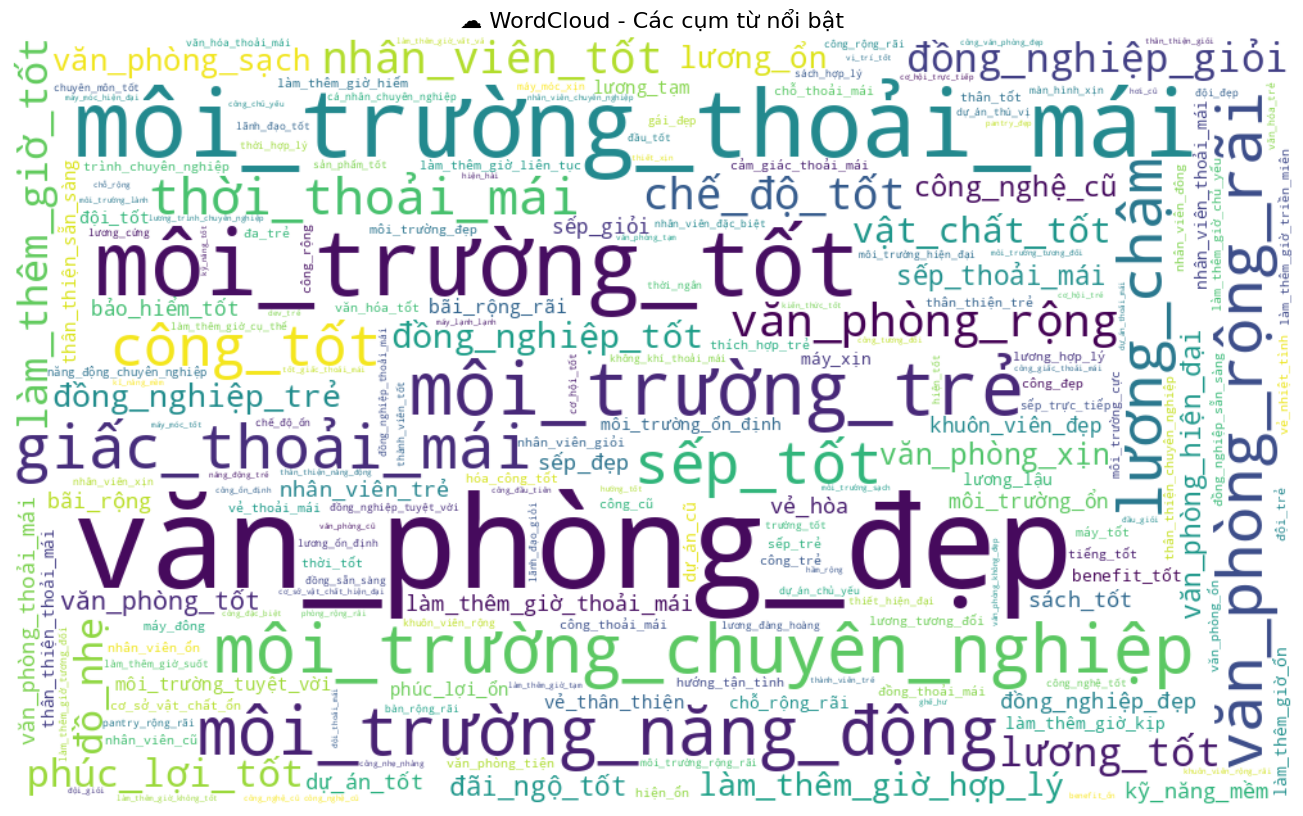

In [ ]:
# Tách cụm danh từ + tính từ hoặc danh từ + không + tính từ và thể hiện nội dung có nghĩa

#Gán nhãn N, A và mặc định 'làm_thêm_giờ' là 'N'
def custom_pos_tag(text):
    tagged = pos_tag(text)
    corrected = []
    for word, tag in tagged:
        if word.lower() == "làm_thêm_giờ":
            corrected.append((word, "N"))  # ép từ 'ot' thành danh từ
        else:
            corrected.append((word, tag))
    return corrected

#Hàm tách cụm từ có nghĩa
def extract_phrases_unique(text):
    words = custom_pos_tag(text)
    used = set()
    phrases_2 = []
    i = 0
    for i in range(len(words) - 1):
        word, tag = words[i]
        next_word, next_tag = words[i + 1]

        # Danh từ + tính từ
        if tag.startswith('N') and next_tag.startswith('A'):
            phrase = f"{word} {next_word}"
            if word not in stopwords_lst and next_word not in stopwords_lst:
                phrases_2.append(phrase)

        # Danh từ + không + tính từ
        if i + 2 < len(words):
            third_word, third_tag = words[i + 2]
            if tag.startswith('N') and next_word == 'không' and third_tag.startswith('A'):
                phrase = f"{word} không {third_word}"
                if word not in stopwords_lst and third_word not in stopwords_lst:
                    phrases_2.append(phrase)
    return phrases_2

df['phrases_2'] = df['clean_text_2'].apply(extract_phrases_unique)

df['phrases_str'] = df['phrases_2'].apply(lambda x: ' '.join([p.replace(" ", "_") for p in x]))


#Hàm vẽ wordcloud
def plot_wordcloud_from_column(df, column_name, title="☁️ WordCloud - Các cụm từ nổi bật"):
    text_all = ' '.join(df[column_name].astype(str))

    wordcloud = WordCloud(width=1000, height=600, background_color="white").generate(text_all)

    plt.figure(figsize=(20, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

#Áp dụng hàm
plot_wordcloud_from_column(df, column_name='phrases_str')

####**Tách cụm và hiển thị nội dung chưa tối ưu, để sau**

In [ ]:
df['phrases_2'].head()

,phrases_2
0,"[môi trường thoải mái, phân công chuyên nghiệp]"
1,"[đẹp công trẻ, giấc thoải mái]"
2,"[internship chuyên nghiệp, tội hơi nóng]"
3,[]
4,"[văn phòng đẹp, vật chất tốt, môi trường thoải..."


##**PHÂN CỤM CÔNG TY THEO TEXT REVIEW (Cột clean_text)**
- Dùng TfidfVectorizer để vector hóa cột clean_text
- Tìm chủ đề ẩn bằng LDA
- Dùng Silhouette để tìm k cụm phù hợp -> phân nhóm cụm công ty bằng Kmeans
- Dùng PCA để giảm chiều dữ liệu và vẽ biểu đồ scatterplot bằng seaborn
- Hiển thị cụm từ đặc trưng của từng cụm công ty + trực quan bằng Wordcloud
- Xuất danh sách phân cụm công ty

In [ ]:
# Vector hóa TfidfVectorizer
tdfvectorizer = TfidfVectorizer(max_df=0.95, min_df=2)
doc_term_matrix = tdfvectorizer.fit_transform(df["phrases_str"])

#Huấn luyện LDA
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_matrix = lda.fit_transform(doc_term_matrix)

In [ ]:
#Chọn K phù hợp
k_list = []
silhouette_scores = []

for k in range(3, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(lda_matrix)
    silhouette = silhouette_score(lda_matrix, labels)
    silhouette_scores.append((k, silhouette))

# In kết quả
for k, score in silhouette_scores:
    print(f"Number of clusters: {k}, Silhouette score: {score:.4f}")

# Chọn k tối ưu
best_k = max(silhouette_scores, key=lambda x: x[1])[0]
print(f"Best number of clusters: {best_k}")

# Bước 5: Phân cụm bằng KMeans trên vector chủ đề
n_clusters = best_k
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df["cluster"] = kmeans.fit_predict(lda_matrix)

# count samples per cluster
df["cluster"].value_counts()

Number of clusters: 3, Silhouette score: 0.4839
Number of clusters: 4, Silhouette score: 0.5454
Number of clusters: 5, Silhouette score: 0.6628
Number of clusters: 6, Silhouette score: 0.7318
Best number of clusters: 6


,count
cluster,
0,3156
1,1337
4,1145
2,1080
5,867
3,826


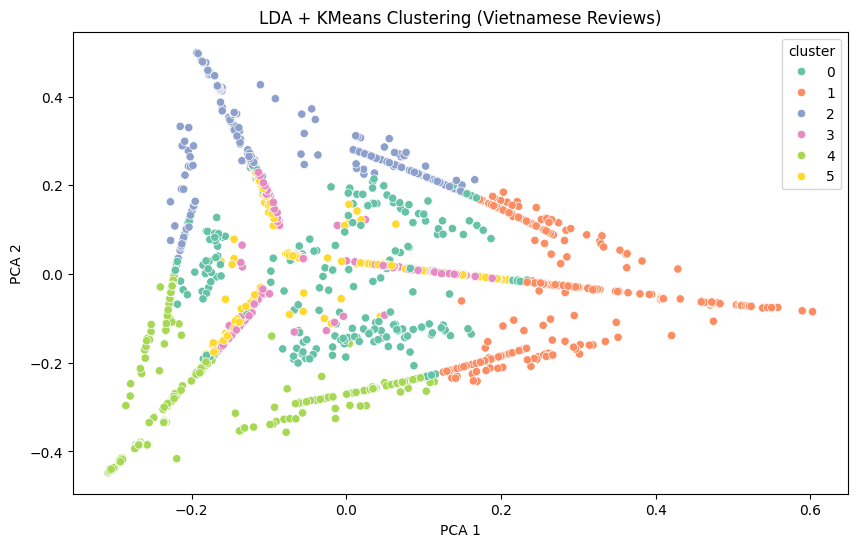

In [ ]:
# Bước 6: Giảm chiều bằng PCA để trực quan
pca = PCA(n_components=2)
coords = pca.fit_transform(lda_matrix)
df["x"] = coords[:, 0]
df["y"] = coords[:, 1]
# tSLE

# Bước 7: Vẽ biểu đồ cụm
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="x", y="y", hue="cluster", palette="Set2")
plt.title("LDA + KMeans Clustering (Vietnamese Reviews)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

In [ ]:
# Bước 8: Hiển thị từ khóa đặc trưng mỗi topic
feature_names = tdfvectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    print(f"Chủ đề #{topic_idx + 1}: {', '.join(top_words)}")

Chủ đề #1: môi_trường_tốt, văn_phòng_rộng_rãi, giấc_thoải_mái, văn_phòng_rộng, công_nghệ_cũ, làm_thêm_giờ_hợp_lý, văn_phòng_tốt, nhân_viên_trẻ, vẻ_thân_thiện, môi_trường_ổn_định
Chủ đề #2: văn_phòng_đẹp, môi_trường_trẻ, sếp_tốt, công_tốt, vật_chất_tốt, văn_phòng_xịn, sếp_thoải_mái, vẻ_hòa, sếp_đẹp, khuôn_viên_đẹp
Chủ đề #3: môi_trường_thoải_mái, môi_trường_chuyên_nghiệp, môi_trường_năng_động, thời_thoải_mái, nhân_viên_tốt, làm_thêm_giờ_tốt, đồng_nghiệp_trẻ, văn_phòng_sạch, sách_tốt, bãi_rộng
Chủ đề #4: lương_chậm, lương_tốt, phúc_lợi_tốt, đồ_nhẹ, lương_ổn, đãi_ngộ_tốt, đội_tốt, làm_thêm_giờ_ổn, thân_tốt, làm_thêm_giờ_hiếm
Chủ đề #5: chế_độ_tốt, đồng_nghiệp_giỏi, đồng_nghiệp_tốt, văn_phòng_hiện_đại, kỹ_năng_mềm, làm_thêm_giờ_thoải_mái, văn_phòng_thoải_mái, đồng_nghiệp_đẹp, bảo_hiểm_tốt, bãi_rộng_rãi


In [ ]:
n_clusters = best_k  # hoặc best_k nếu đã tìm được
n_top_words = 10

df_clusters = pd.DataFrame(lda_matrix)
df_clusters['cluster'] = df['cluster']  # nhãn cụm từ KMeans

# Khởi tạo dict lưu từ khóa theo cụm
cluster_keywords_dict = {}

# Lặp qua từng cụm
for cluster_num in range(n_clusters):
    print(f"\n📂 Cụm {cluster_num}:")

    # Trung bình các topic phân phối trong cụm
    cluster_topic_dist = df_clusters[df_clusters['cluster'] == cluster_num].drop('cluster', axis=1).mean()

    # Lấy 2 topic trội nhất trong cụm
    top_topics = cluster_topic_dist.sort_values(ascending=False).index[:2]

    cluster_keywords = []  # dùng để lưu từ khóa đại diện toàn cụm

    for topic_idx in top_topics:
        weight = cluster_topic_dist[topic_idx]
        top_words = [feature_names[i] for i in lda.components_[topic_idx].argsort()[:-n_top_words-1:-1]]

        # In chủ đề chi tiết
        print(f"  🧩 Chủ đề {topic_idx} (trọng số: {weight:.4f}): {', '.join(top_words)}")

        # Gộp từ khóa để làm mô tả cụm
        cluster_keywords.extend(top_words)

    # In từ khóa đặc trưng toàn cụm (gộp từ 2 chủ đề)
    print(f"📌 Từ khóa đặc trưng của cụm {cluster_num}: {', '.join(cluster_keywords)}")

    # Lưu từ khóa vào dict
    cluster_keywords_dict[cluster_num] = ', '.join(cluster_keywords)


📂 Cụm 0:
  🧩 Chủ đề 1 (trọng số: 0.2187): văn_phòng_đẹp, môi_trường_trẻ, sếp_tốt, công_tốt, vật_chất_tốt, văn_phòng_xịn, sếp_thoải_mái, vẻ_hòa, sếp_đẹp, khuôn_viên_đẹp
  🧩 Chủ đề 2 (trọng số: 0.2120): môi_trường_thoải_mái, môi_trường_chuyên_nghiệp, môi_trường_năng_động, thời_thoải_mái, nhân_viên_tốt, làm_thêm_giờ_tốt, đồng_nghiệp_trẻ, văn_phòng_sạch, sách_tốt, bãi_rộng
📌 Từ khóa đặc trưng của cụm 0: văn_phòng_đẹp, môi_trường_trẻ, sếp_tốt, công_tốt, vật_chất_tốt, văn_phòng_xịn, sếp_thoải_mái, vẻ_hòa, sếp_đẹp, khuôn_viên_đẹp, môi_trường_thoải_mái, môi_trường_chuyên_nghiệp, môi_trường_năng_động, thời_thoải_mái, nhân_viên_tốt, làm_thêm_giờ_tốt, đồng_nghiệp_trẻ, văn_phòng_sạch, sách_tốt, bãi_rộng

📂 Cụm 1:
  🧩 Chủ đề 1 (trọng số: 0.2834): văn_phòng_đẹp, môi_trường_trẻ, sếp_tốt, công_tốt, vật_chất_tốt, văn_phòng_xịn, sếp_thoải_mái, vẻ_hòa, sếp_đẹp, khuôn_viên_đẹp
  🧩 Chủ đề 2 (trọng số: 0.1902): môi_trường_thoải_mái, môi_trường_chuyên_nghiệp, môi_trường_năng_động, thời_thoải_mái, nhân_viên_

In [ ]:
# Đếm số bình luận theo từng (Company Name, cluster)
company_cluster_counts = df.groupby(['Company Name', 'cluster']).size().reset_index(name='count')

# Tính tổng số bình luận theo từng công ty
total_counts_per_company = company_cluster_counts.groupby('Company Name')['count'].transform('sum')

# Thêm cột tỷ lệ %
company_cluster_counts['percent'] = (company_cluster_counts['count'] / total_counts_per_company * 100).round(2)

# Chỉ giữ lại cột cần thiết
company_cluster_percents = company_cluster_counts[['Company Name', 'cluster','percent']]

# Sắp xếp và lấy top 2 cụm có tỷ lệ cao nhất cho mỗi công ty
top2_percent_clusters = (
    company_cluster_percents
    .sort_values(['Company Name', 'percent'], ascending=[True, False])
    .groupby('Company Name')
    .head(2)
)

#Thêm cột keyword chứa từ khóa đặc trưng của cụm đó
top2_percent_clusters['keyword'] = top2_percent_clusters['cluster'].map(cluster_keywords_dict)

top2_percent_clusters.head()

,Company Name,cluster,percent,keyword
4,"ANDPAD VietNam Co., Ltd",5,40.00,"lương_chậm, lương_tốt, phúc_lợi_tốt, đồ_nhẹ, l..."
0,"ANDPAD VietNam Co., Ltd",0,30.00,"văn_phòng_đẹp, môi_trường_trẻ, sếp_tốt, công_t..."
9,ARIS Vietnam,4,23.08,"môi_trường_thoải_mái, môi_trường_chuyên_nghiệp..."
5,ARIS Vietnam,0,15.38,"văn_phòng_đẹp, môi_trường_trẻ, sếp_tốt, công_t..."
11,"AZPLAYS Co., LTD",0,83.33,"văn_phòng_đẹp, môi_trường_trẻ, sếp_tốt, công_t..."


In [ ]:
# Xuất kết quả
top2_percent_clusters.to_csv('top2_clusters_per_company.csv', index=False)

##**PHÂN NHÓM CÔNG TY THÀNH POSIIVE, NEUTRAL, NEGATIVE (Dựa trên 6 cột điểm đánh giá)**
- Chuyển đổi từng điểm đánh giá thành sentiment
- Gán nhãn sentiment cho mỗi review dựa trên tỉ lệ % sentiment cao nhất của 6 cột
(bằng nhau xem là neutral, còn 50% neutral và 50% positive thì xem là positive)
- Gán nhãn sentiment cho mỗi công ty dựa trên tỉ lệ % sentiment cao nhất của tổng các reviews (TH đặc biệt như trên)
- Xuất danh sách phân nhóm công ty "sentiment_by_company.csv"

In [ ]:
score_cols = [
    'Rating',
    'Salary & benefits',
    'Training & learning',
    'Management cares about me',
    'Culture & fun',
    'Office & workspace'
]

#Gán nhãn sentiment cho từng review
def map_sentiment(score):
    if score >= 4.0:
        return 'positive'
    elif score >= 3.0:
        return 'neutral'
    else:
        return 'negative'

# Ánh xạ từng điểm sang sentiment
for col in score_cols:
    df[f'{col}_sentiment'] = df[col].apply(map_sentiment)

# Gom toàn bộ các cột sentiment lại để tính tỉ lệ
sentiment_cols = [f'{col}_sentiment' for col in score_cols]

# Tính số sentiment theo từng loại
df['positive_count'] = df[sentiment_cols].apply(lambda row: (row == 'positive').sum(), axis=1)
df['neutral_count'] = df[sentiment_cols].apply(lambda row: (row == 'neutral').sum(), axis=1)
df['negative_count'] = df[sentiment_cols].apply(lambda row: (row == 'negative').sum(), axis=1)

# Tính tổng để lấy tỉ lệ %
df['total_count'] = df[['positive_count', 'neutral_count', 'negative_count']].sum(axis=1)
df['positive_pct'] = (df['positive_count'] / df['total_count'] * 100).round(2)
df['neutral_pct'] = (df['neutral_count'] / df['total_count'] * 100).round(2)
df['negative_pct'] = (df['negative_count'] / df['total_count'] * 100).round(2)

# Gán sentiment cho mỗi review (Chọn sentiment có % cao nhất, 3 cái bằng nhau → gán neutral)
def pick_sentiment(row):
    pos = row['positive_pct']
    neu = row['neutral_pct']
    neg = row['negative_pct']
    # Trường hợp đặc biệt: 50% pos + 50% neu + 0% neg → chọn pos
    if pos == 50.0 and neu == 50.0 and neg == 0.0:
        return 'positive'
    sentiments = {
        'positive': pos,
        'neutral': neu,
        'negative': neg
    }
    max_value = max(sentiments.values())
    max_sentiments = [k for k, v in sentiments.items() if v == max_value]
    if len(max_sentiments) > 1:
        return 'neutral'
    else:
        return max_sentiments[0]

df['review_sentiment'] = df.apply(pick_sentiment, axis=1)

In [ ]:
df[['clean_text_2','review_sentiment']].head()

,clean_text_2,review_sentiment
0,môi trường thoải mái áp lực thể kết hợp lương ...,positive
1,cơ sở vật chất đẹp công trẻ năng động chế độ k...,positive
2,mội thân thiện giúp đỡ lẫn chương trình intern...,neutral
3,tốt env viên trường học cải thiện khả năng yên...,neutral
4,văn phòng đẹp cơ sở vật chất tốt sếp đồng nghi...,positive


In [ ]:
df[['Company Name',
    'positive_pct',
    'neutral_pct',
    'negative_pct',
    'review_sentiment']].head()

,Company Name,positive_pct,neutral_pct,negative_pct,review_sentiment
0,Accenture,100.00,0.00,0.00,positive
1,Accenture,83.33,16.67,0.00,positive
2,Accenture,0.00,100.00,0.00,neutral
3,Accenture,33.33,33.33,33.33,neutral
4,Accenture,66.67,33.33,0.00,positive


In [ ]:
#Tính tỷ lệ sentiment theo công ty
sentiment_counts = df.groupby(['Company Name', 'review_sentiment']).size().unstack(fill_value=0)

#Tính tỷ lệ (rate) theo từng nhóm sentiment
sentiment_rates = (sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100).round(2)

#Gán sentiment cho công ty theo %sentiment cao nhất
def assign_sentiment(row):
    pos = row['positive']
    neu = row['neutral']
    neg = row['negative']
    # Trường hợp đặc biệt: 50% positive, 50% neutral, 0% negative → xem là positive
    if pos == 50.0 and neu == 50.0 and neg == 0.0:
        return 'positive'
    # Trường hợp có 3 sentiment bằng nhau → xem là neutral
    sentiments = row[['positive', 'neutral', 'negative']]
    if (sentiments == sentiments.max()).sum() > 1:
        return 'neutral'
    else:
        return sentiments.idxmax()

sentiment_rates['sentiment_group'] = sentiment_rates.apply(assign_sentiment, axis=1)

#Đưa tên công ty về thành cột bình thường
result= sentiment_rates.reset_index()

In [ ]:
result.head()

review_sentiment,Company Name,negative,neutral,positive,sentiment_group
0,"ANDPAD VietNam Co., Ltd",0.00,0.00,100.00,positive
1,ARIS Vietnam,7.69,38.46,53.85,positive
2,"AZPLAYS Co., LTD",0.00,33.33,66.67,positive
3,AZoom VietNam,0.00,20.00,80.00,positive
4,Accenture,5.56,27.78,66.67,positive


In [ ]:
# result.to_csv('sentiment_by_company.csv', index=False)

##**DỰ ĐOÁN SENTIMENT CHO ĐẦU VÀO LÀ TEXT REVIEW (Cột clean_text_2)**



In [ ]:
# Lấy 2 cột cần thiết
data = df[["clean_text_2", "review_sentiment"]].copy()

# Đổi tên cột cho PyCaret dễ nhận
data.rename(columns={"clean_text_2": "text", "review_sentiment": "label"}, inplace=True)

# Chia dữ liệu train/test theo tỉ lệ 80/20
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data["label"])

In [ ]:
!pip install transformers datasets

In [ ]:
data["label"].value_counts()

,count
label,
positive,6380
neutral,1490
negative,541


In [ ]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_data)
test_dataset = Dataset.from_pandas(test_data)



In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

def tokenize_fn(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

train_dataset = train_dataset.map(tokenize_fn)
test_dataset = test_dataset.map(tokenize_fn)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

Map:   0%|          | 0/6728 [00:00<?, ? examples/s]

Map:   0%|          | 0/1683 [00:00<?, ? examples/s]

In [ ]:
label_map = {"negative": 0, "neutral": 1, "positive": 2}

def encode_labels(example):
    example["label"] = label_map[example["label"]]
    return example

train_dataset = train_dataset.map(encode_labels)
test_dataset = test_dataset.map(encode_labels)


Map:   0%|          | 0/6728 [00:00<?, ? examples/s]

Map:   0%|          | 0/1683 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "vinai/phobert-base",
    num_labels=3  # vì bạn có 3 lớp: negative, neutral, positive
)


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install --upgrade transformers


In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.5 MB/s eta 0:00:00


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
)



In [ ]:
import evaluate
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="weighted")["f1"]
    }


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


<ipython-input-39-726133461>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: tribuoichimto (tribuoichimto-ad) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss


In [ ]:
# 👉 Setup PyCaret (tự động TF-IDF, encoding, etc.)
clf1 = setup(
    data=train_data,
    target="label",
    session_id=42,
    verbose=False,
    text_features=["text"])

In [ ]:
# So sánh và chọn mô hình tốt nhất
compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,05:17:51
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Quadratic Discriminant Analysis


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7630,0.0000,0.7630,0.7101,0.6973,0.1375,0.1874,8.6160
ridge,Ridge Classifier,0.7602,0.0000,0.7602,0.7068,0.7003,0.1497,0.1908,7.3060
rf,Random Forest Classifier,0.7575,0.7347,0.7575,0.6228,0.6554,0.0025,0.0118,8.5910
svm,SVM - Linear Kernel,0.7569,0.0000,0.7569,0.7030,0.7116,0.1981,0.2242,6.1930
knn,K Neighbors Classifier,0.7273,0.6563,0.7273,0.6719,0.6897,0.1400,0.1499,3.5280
dt,Decision Tree Classifier,0.6636,0.5677,0.6636,0.6569,0.6600,0.1186,0.1188,6.5280
nb,Naive Bayes,0.3980,0.5484,0.3980,0.6534,0.4767,0.0373,0.0466,1.9190


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
#Tạo mô hình có chỉ số tốt nhất
svm = create_model('svm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7473,0.0000,0.7473,0.6953,0.7102,0.1988,0.2151
1,0.7495,0.0000,0.7495,0.6932,0.7103,0.1956,0.2129
2,0.7452,0.0000,0.7452,0.6623,0.6844,0.1132,0.1394
3,0.7601,0.0000,0.7601,0.7168,0.7204,0.2185,0.2424
4,0.7537,0.0000,0.7537,0.7410,0.7213,0.2287,0.2436
5,0.7771,0.0000,0.7771,0.7357,0.7382,0.2738,0.3038
6,0.7643,0.0000,0.7643,0.7101,0.7143,0.1997,0.2365
7,0.7389,0.0000,0.7389,0.6648,0.6916,0.1549,0.1721
8,0.7537,0.0000,0.7537,0.6762,0.6995,0.1747,0.2027


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
#Turning mô hình
tuned_model = tune_model(svm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7643,0.0000,0.7643,0.7085,0.6909,0.1054,0.1639
1,0.7558,0.0000,0.7558,0.6705,0.6824,0.0902,0.1299
2,0.7495,0.0000,0.7495,0.6562,0.6691,0.0508,0.0811
3,0.7622,0.0000,0.7622,0.6926,0.6762,0.0722,0.1385
4,0.7622,0.0000,0.7622,0.7080,0.6909,0.1123,0.1683
5,0.7771,0.0000,0.7771,0.7322,0.7163,0.1980,0.2622
6,0.7580,0.0000,0.7580,0.6587,0.6695,0.0494,0.0987
7,0.7431,0.0000,0.7431,0.6264,0.6598,0.0259,0.0414
8,0.7495,0.0000,0.7495,0.6553,0.6782,0.0908,0.1234


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
# Dự đoán trên tập test
preds = predict_model(svm, data=test_data)

# 👉 Xem kết quả
preds.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Linear Kernel,0.7558,0,0.7558,0.7010,0.7093,0.1818,0.2086


,text,label,prediction_label
5116,1 công môi trường thân thiện vẻ 2 học sách sếp...,positive,positive
5762,hòa đồng mến đặc biệt chiều dev hướng siêu thư...,positive,positive
7430,1 đồng nghiệp thân thiện nhiệt tình 2 môi trườ...,neutral,positive
3941,trợ hoạt động đội xây dựng thân thiện đánh giá...,negative,negative
3549,lương công tuỳ dự án dự án chạy làm_thêm_giờ d...,negative,positive


In [ ]:
# Thêm cột kiểm tra đúng/sai
preds["correct"] = preds["prediction_label"] == preds["label"]

# Tổng số mẫu theo từng nhãn
total_counts = preds["label"].value_counts()

# Số mẫu dự đoán đúng theo từng nhãn
correct_counts = preds[preds["correct"] == True]["label"].value_counts()

# Tính tỷ lệ % đúng
accuracy_per_class = (correct_counts / total_counts * 100).round(2)

# Hiển thị kết quả
print("📊 Tỷ lệ dự đoán đúng theo từng nhóm:")
print(accuracy_per_class)

📊 Tỷ lệ dự đoán đúng theo từng nhóm:
label
positive    94.60
neutral     15.10
negative    17.59
Name: count, dtype: float64


###Đánh giá mô hình bằng các chỉ số

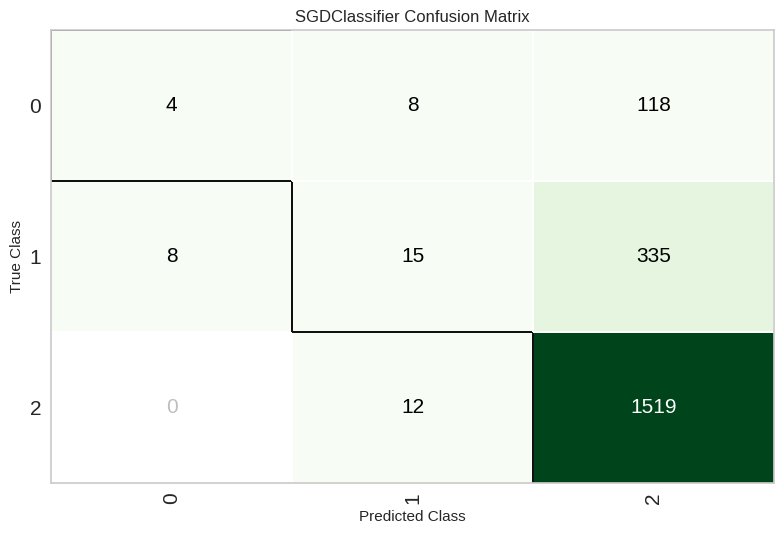

In [ ]:
# Vẽ confustion_matrix
plot_model(estimator = tuned_model, plot = 'confusion_matrix')

##**NHẬP TÊN CÔNG TY ĐỂ XEM:**
- Phân nhóm sentiment của công ty: Positive hay Neutral hay Negative (có hiển thị % đánh giá chi tiêt)
- Phân cụm đặc trưng của công ty: cụm 1, 2, 3, 4..
- Cụm từ đặc trưng của cụm
- Wordcloud đặc trưng của cụm

Nếu tên công ty không có trong danh sách thì hiển thị là "Không có đánh giá trên ITViec"

In [ ]:
cluster_desc = {
    0: (
        "Cụm 0 – Văn hoá vui vẻ & benefit tốt.\n"
        "• Đồng nghiệp thân thiện, không khí năng động.\n"
        "• Giờ giấc linh hoạt, OT minh bạch.\n"
        "• Cơ sở vật chất ổn – campus đẹp, macbook, benefit hấp dẫn."
    ),

    1: (
        "Cụm 1 – Văn phòng đẹp nhưng lương/benefit còn lấn cấn.\n"
        "• Không gian rộng, thiết bị xịn, môi trường chuyên nghiệp.\n"
        "• Nhân sự trẻ, thích giờ giấc thoải mái.\n"
        "• Phản ánh lương chủ yếu ở mức 'cơ bản', cần cạnh tranh hơn."
    ),

    2: (
        "Cụm 2 – Năng động – trẻ – chuyên nghiệp.\n"
        "• Văn phòng đẹp + macbook chuyên nghiệp.\n"
        "• Nhiều intern/trainee, đồng nghiệp giỏi.\n"
        "• Chính sách OT rõ ràng, benefit tốt."
    ),

    3: (
        "Cụm 3 – Ổn định truyền thống, tech-stack bắt đầu cũ.\n"
        "• Công ty tốt, thời gian thoải mái.\n"
        "• Nhắc nhiều tới kỹ năng mềm, dự án 'tốt vừa'.\n"
        "• Công nghệ cũ được nêu như điểm trừ."
    ),

    4: (
        "Cụm 4 – Phúc lợi tốt nhưng quy trình lương gặp vấn đề.\n"
        "• Môi trường thoải mái, quy trình rõ ràng.\n"
        "• Đồng nghiệp trẻ, phúc lợi ổn.\n"
        "• Than phiền lương chậm / trung bình."
    ),

    5: (
        "Cụm 5 – Chính sách rõ, môi trường trẻ, lương đầy đủ.\n"
        "• OT minh bạch, văn phòng hiện đại.\n"
        "• Đồng nghiệp giỏi, culture 'gen-Z friendly'.\n"
        "• Được khen lương xứng đáng, chính sách rõ ràng."
    ),
}


cluster_suggest = {
    0: (
        "- Duy trì hoạt động gắn kết (teambuilding, CLB sở thích).\n"
        "- Giữ minh bạch OT, khen thưởng kịp thời.\n"
        "- Triển khai chương trình chia sẻ kiến thức nội bộ."
    ),

    1: (
        "- Rà soát thang lương, đảm bảo cạnh tranh thị trường.\n"
        "- Truyền thông rõ ràng benefit, giảm kỳ vọng lệch.\n"
        "- Tổ chức workshop phát triển kỹ năng mềm cho nhân viên trẻ."
    ),

    2: (
        "- Thiết lập lộ trình career rõ cho intern/trainee.\n"
        "- Duy trì hackathon, tech-talk để giữ nhịp năng động.\n"
        "- Triển khai mentorship & coaching cho middle-level."
    ),

    3: (
        "- Lên roadmap nâng cấp cơ sở vật chất, công nghệ mới.\n"
        "- Cấp ngân sách chứng chỉ & khóa học kỹ thuật.\n"
        "- Tổ chức hackday nội bộ để thử nghiệm sáng tạo."
    ),

    4: (
        "- Thiết lập deadline cố định cho pay-run, phòng ngừa lương chậm.\n"
        "- Triển khai lương thưởng linh hoạt.\n"
        "- Truyền thông minh bạch KPI trả lương, giảm hoài nghi."
    ),

    5: (
        "- Công bố OT/lương công khai nội bộ.\n"
        "- Phát triển chương trình leadership cho.\n"
        "- Bổ sung phúc lợi well-being (mental day, gym, health-check)."
    ),
}


def show_company_sentiment(company_name: str):
    # 2.1. Sentiment score
    matched_data = result[result['Company Name']
                          .str.lower()
                          .str.contains(company_name.lower())]
    if matched_data.empty:
        print(f"❌ Không có đánh giá trên ITviec cho công ty: “{company_name}”")
        return

    print(f"🔎 KẾT QUẢ ĐÁNH GIÁ – {company_name}")
    display(matched_data[['positive', 'neutral', 'negative', 'sentiment_group']])

    # 2.2. Cluster & keyword
    matched_clusters = top2_percent_clusters[top2_percent_clusters['Company Name']
                                             .str.lower()
                                             .str.contains(company_name.lower())]
    if matched_clusters.empty:
        print("⚠️ Không tìm thấy thông tin cụm/keyword.")
        return

    # Dominant cluster (tỷ trọng cao nhất)
    dom_row   = matched_clusters.loc[matched_clusters['percent'].idxmax()]
    c_id      = int(dom_row['cluster'])
    c_share   = dom_row['percent']

    print(f"\n CỤM CHÍNH: #{c_id} – chiếm {c_share:.1f}%")
    print("• Đặc trưng: \n", cluster_desc.get(c_id, "Chưa có mô tả."))
    print("• Gợi ý cải tiến   : \n", cluster_suggest.get(c_id, "Chưa có gợi ý."))

    # 2.3. Bảng chi tiết clusters
    print("\n📊 Tỷ trọng các cụm của công ty:")
    display(matched_clusters[['cluster','percent','keyword']]
            .sort_values('percent', ascending=False)
            .style.format({'percent':'{:.1f}%'}))

    # 2.4. Bar chart
    plt.figure(figsize=(6,3))
    sns.barplot(data=matched_clusters, x='cluster', y='percent', palette='rocket')
    plt.ylabel('% đóng góp'); plt.title('Tỷ trọng theo cụm')
    plt.show()
    print("")
    print("")
    # 2.5. WordCloud keywords
    keywords_text = ' '.join(matched_clusters['keyword'].astype(str))
    wc = WordCloud(width=800, height=350, background_color='white').generate(keywords_text)

    plt.figure(figsize=(10,4))
    plt.imshow(wc, interpolation='bilinear'); plt.axis("off")
    plt.title(f"Từ khóa đặc trưng – {company_name}")
    plt.show()

Nhập tên công ty cần tra cứu: aris
🔎 KẾT QUẢ ĐÁNH GIÁ – aris


review_sentiment,positive,neutral,negative,sentiment_group
1,53.85,38.46,7.69,positive



 CỤM CHÍNH: #4 – chiếm 23.1%
• Đặc trưng: 
 Cụm 4 – Phúc lợi tốt nhưng quy trình lương gặp vấn đề.
• Môi trường thoải mái, quy trình rõ ràng.
• Đồng nghiệp trẻ, phúc lợi ổn.
• Than phiền lương chậm / trung bình.
• Gợi ý cải tiến   : 
 - Thiết lập deadline cố định cho pay-run, phòng ngừa lương chậm.
- Triển khai lương thưởng linh hoạt.
- Truyền thông minh bạch KPI trả lương, giảm hoài nghi.

📊 Tỷ trọng các cụm của công ty:


,cluster,percent,keyword
9,4,23.1%,"môi_trường_thoải_mái, môi_trường_chuyên_nghiệp, môi_trường_năng_động, thời_thoải_mái, nhân_viên_tốt, làm_thêm_giờ_tốt, đồng_nghiệp_trẻ, văn_phòng_sạch, sách_tốt, bãi_rộng, văn_phòng_đẹp, môi_trường_trẻ, sếp_tốt, công_tốt, vật_chất_tốt, văn_phòng_xịn, sếp_thoải_mái, vẻ_hòa, sếp_đẹp, khuôn_viên_đẹp"
5,0,15.4%,"văn_phòng_đẹp, môi_trường_trẻ, sếp_tốt, công_tốt, vật_chất_tốt, văn_phòng_xịn, sếp_thoải_mái, vẻ_hòa, sếp_đẹp, khuôn_viên_đẹp, môi_trường_thoải_mái, môi_trường_chuyên_nghiệp, môi_trường_năng_động, thời_thoải_mái, nhân_viên_tốt, làm_thêm_giờ_tốt, đồng_nghiệp_trẻ, văn_phòng_sạch, sách_tốt, bãi_rộng"


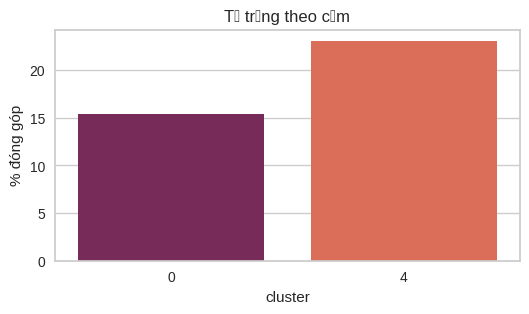

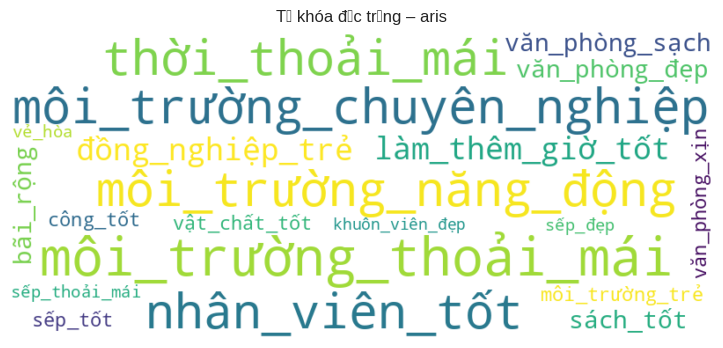

In [ ]:
company_input = input("Nhập tên công ty cần tra cứu: ")
show_company_sentiment(company_input)